In [11]:
import torch
from src.a_mps_torch import MPS, init_random_mps, init_spinup_MPS
from src.b_model_torch import TFIModel
from src.dmrg import DMRGEngine
from src.tfi_exact import finite_gs_energy
import src.tebd_torch as tebd
import src.gd as gd

In [25]:
L = 14
J = 1.0
g = 1.5

theoretical_energy = finite_gs_energy(L, J, g)
print(f"Theoretical ground state energy: {theoretical_energy:.6f}")

psi = init_random_mps(L, chi_max=30) 
model = TFIModel(L, J=J, g=g)

Theoretical ground state energy: -23.222959


In [29]:
# DMRG
def run_dmrg(chi_max, num_sweeps):
    """Performs DMRG and returns the energy history."""
    print("\n--- Running DMRG ---")
    psi_dmrg = psi.copy()
    eng = DMRGEngine(psi_dmrg, model, chi_max=chi_max)
    
    initial_energy = model.energy(psi_dmrg)/ psi_dmrg.norm_squared()
    energies = [initial_energy.item()]
    # energies = []

    for sweep in range(num_sweeps):
        eng.sweep()
        # After a sweep, the MPS norm is ~1, so we can use the unnormalized energy
        energy = model.energy(eng.psi)
        energies.append(energy)
        err = abs((energy - theoretical_energy) / theoretical_energy)
        print(f"Sweep {sweep + 1:2d} | Energy = {energy:.12f} | rel. error {err:.4e}")
    
    return energies

energies_dmrg = run_dmrg(chi_max=30, num_sweeps=10)
energies_dmrg


--- Running DMRG ---
Sweep  1 | Energy = -23.222961599133 | rel. error 9.3227e-08
Sweep  2 | Energy = -23.222959434117 | rel. error 2.2947e-15
Sweep  3 | Energy = -23.222959434117 | rel. error 2.4477e-15
Sweep  4 | Energy = -23.222959434117 | rel. error 2.4477e-15
Sweep  5 | Energy = -23.222959434117 | rel. error 2.4477e-15
Sweep  6 | Energy = -23.222959434117 | rel. error 2.2947e-15
Sweep  7 | Energy = -23.222959434117 | rel. error 2.2947e-15
Sweep  8 | Energy = -23.222959434117 | rel. error 2.2947e-15
Sweep  9 | Energy = -23.222959434117 | rel. error 2.2947e-15
Sweep 10 | Energy = -23.222959434117 | rel. error 2.4477e-15


[-1.1600285181754447e-14,
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64),
 tensor(-23.2230, dtype=torch.float64)]

In [30]:
# TEBD
def run_tebd(L, chi_max, num_steps=100, dt=0.01):
    """Performs imaginary time TEBD and returns the energy history."""
    print("\n--- Running TEBD ---")
    
    # TEBD is often started from a simple product state
    psi_tebd = init_spinup_MPS(L)
    U_bonds = tebd.calc_U_bonds(model, dt)
    
    initial_energy = model.energy(psi_tebd)
    energies = [initial_energy.item()]

    for step in range(num_steps):
        tebd.run_TEBD(psi_tebd, U_bonds, N_steps=1, chi_max=chi_max, eps=1.e-14)
        energy = model.energy(psi_tebd)
        energies.append(energy)
        if step % 20 == 0 or step == num_steps - 1:
            print(f"Step {step:5d} | Time = {dt*(step+1):.2f} | Energy = {energy:.12f}")

    return energies

# tebd.example_TEBD_gs_finite(L, J, g)
energies_tebd = run_tebd(L, chi_max=30)


--- Running TEBD ---
Step     0 | Time = 0.01 | Energy = -21.244932310001
Step    20 | Time = 0.21 | Energy = -22.987806989314
Step    40 | Time = 0.41 | Energy = -23.175322947266
Step    60 | Time = 0.61 | Energy = -23.205068602150
Step    80 | Time = 0.81 | Energy = -23.211293491326
Step    99 | Time = 1.00 | Energy = -23.212781105613


In [31]:
def run_gradient_descent(num_steps, learning_rate):
    """Performs gradient descent and returns the energy history."""
    print("\n--- Running Gradient Descent ---")
    psi_gd = psi.copy()
    for B in psi_gd.Bs:
        B.requires_grad = True
    for S in psi_gd.Ss:
        S.requires_grad = True

    # Re-enable gradients on the copied tensors for this optimization run
    for tensor in psi_gd.get_tensors_as_list():
        tensor.requires_grad = True

    optimizer = torch.optim.Adam(psi_gd.get_tensors_as_list(), lr=learning_rate)
    energies = []

    for step in range(num_steps):
        optimizer.zero_grad() # zero gradient from previous step
        loss =  model.energy_mpo(psi_gd) / psi_gd.norm_squared()
        
        loss.backward() # backward propagation to use Pytorch's autograd
        
		# update all MPS tensors
        optimizer.step()
        
		# store and print energy for monitoring
        current_energy = loss.item()
        energies.append(current_energy)
        if step % 10 == 0 or step == num_steps - 1:
            print(f"Step {step:5d} | Energy = {current_energy:.12f}")
            
    return energies

energies_gd = run_gradient_descent(num_steps=100, learning_rate=0.1)


--- Running Gradient Descent ---
Step     0 | Energy = 0.406683137564
Step    10 | Energy = -22.140734217504
Step    20 | Energy = -22.855917306549
Step    30 | Energy = -23.052176488364
Step    40 | Energy = -23.148756532217
Step    50 | Energy = -23.185769720867
Step    60 | Energy = -23.208182989416
Step    70 | Energy = -23.212199608606
Step    80 | Energy = -23.215694994726
Step    90 | Energy = -23.217818148777
Step    99 | Energy = -23.219033792467



--- Generating Plots ---


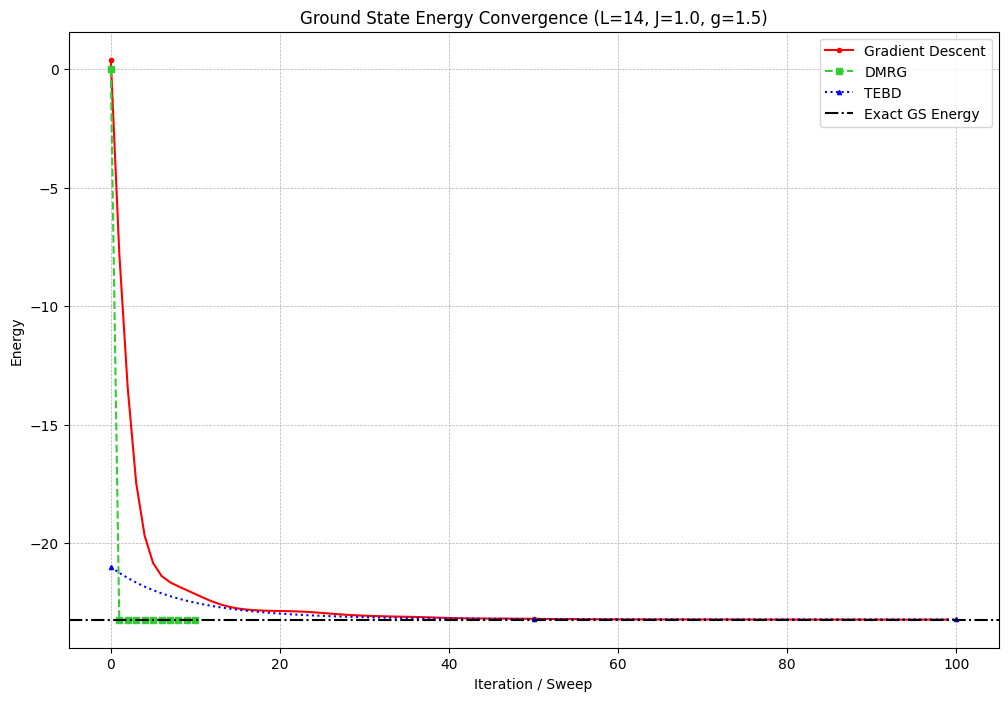

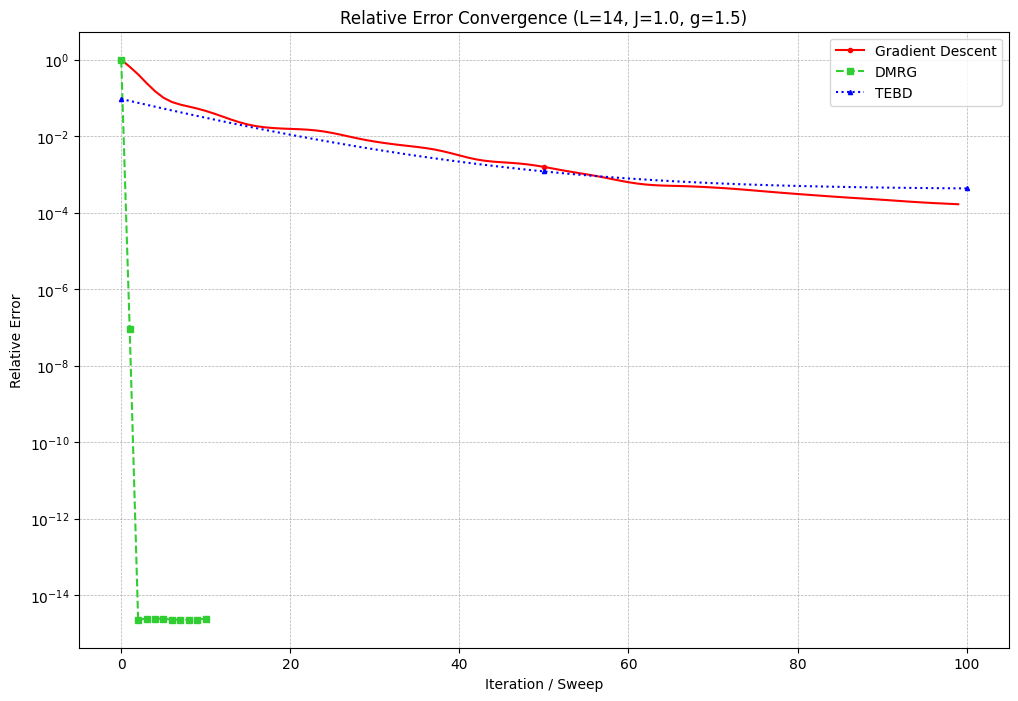

In [33]:
# =============================================================================
# 3. Plotting the Comparison
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("\n--- Generating Plots ---")

# Plot 1: Energy Convergence
plt.figure(figsize=(12, 8))
plt.plot(energies_gd, label='Gradient Descent', color='red', marker='o', markersize=3, linestyle='-', markevery=50)
# DMRG sweeps are much more powerful, so we plot vs sweeps (not individual updates)
plt.plot(np.arange(len(energies_dmrg)), energies_dmrg, label='DMRG', color='limegreen', marker='s', markersize=5, linestyle='--')
plt.plot(energies_tebd, label='TEBD', color='blue', marker='^', markersize=3, linestyle=':', markevery=50)

plt.axhline(y=theoretical_energy, color='black', linestyle='-.', label=f'Exact GS Energy')

plt.xlabel("Iteration / Sweep")
plt.ylabel("Energy")
plt.title(f"Ground State Energy Convergence (L={L}, J={J}, g={g})")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plot 2: Relative Error Convergence (Log Scale)
rel_error_gd = [abs((E - theoretical_energy) / theoretical_energy) for E in energies_gd]
rel_error_dmrg = [abs((E - theoretical_energy) / theoretical_energy) for E in energies_dmrg]
rel_error_tebd = [abs((E - theoretical_energy) / theoretical_energy) for E in energies_tebd]

plt.figure(figsize=(12, 8))
plt.semilogy(rel_error_gd, label='Gradient Descent', color='red', marker='o', markersize=3, linestyle='-', markevery=50)
plt.semilogy(np.arange(len(rel_error_dmrg)), rel_error_dmrg, label='DMRG', color='limegreen', marker='s', markersize=5, linestyle='--')
plt.semilogy(rel_error_tebd, label='TEBD', color='blue', marker='^', markersize=3, linestyle=':', markevery=50)

plt.xlabel("Iteration / Sweep")
plt.ylabel("Relative Error")
plt.title(f"Relative Error Convergence (L={L}, J={J}, g={g})")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.ylim(bottom=1e-7) # Set a lower limit for the y-axis to see convergence floor
plt.show()